In [1]:
import glob, os

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve
from joblib import Parallel, delayed

In [5]:
data_folder = "./data"

In [6]:
iq_data_path = f"{data_folder}/IQdata_numpy/IQdata"

In [7]:
spectrogram_path = f"{data_folder}/spectrogram_numpy/spectrogram"

In [8]:
for file in glob.glob(f"{iq_data_path}/*.npy"):
    print(file)

./data/IQdata_numpy/IQdata/Chirp_2_label.npy
./data/IQdata_numpy/IQdata/3.565-Chirp_4.npy
./data/IQdata_numpy/IQdata/3.565-Chirp_3.npy
./data/IQdata_numpy/IQdata/3.565-Chirp_3_label.npy
./data/IQdata_numpy/IQdata/3.555-Chirp_2.npy
./data/IQdata_numpy/IQdata/3.555-Chirp_3.npy
./data/IQdata_numpy/IQdata/3.555-Chirp_3_label.npy
./data/IQdata_numpy/IQdata/Chirp_1.npy
./data/IQdata_numpy/IQdata/3.565-Chirp_4_label.npy
./data/IQdata_numpy/IQdata/Chirp_1_label.npy
./data/IQdata_numpy/IQdata/Chirp_2.npy
./data/IQdata_numpy/IQdata/3.555-Chirp_2_label.npy


# IQ Samples

In [9]:
ch1_data = []
ch2_data = []
ch1_labels = []
ch2_labels = []

ch1_data.append(np.load(f'{iq_data_path}/3.565-Chirp_3.npy'))
ch1_labels.append(np.load(f'{iq_data_path}/3.565-Chirp_3_label.npy'))
ch1_data.append(np.load(f'{iq_data_path}/3.565-Chirp_4.npy'))
ch1_labels.append(np.load(f'{iq_data_path}/3.565-Chirp_4_label.npy'))


ch2_data.append(np.load(f'{iq_data_path}/3.555-Chirp_2.npy'))
ch2_labels.append(np.load(f'{iq_data_path}/3.555-Chirp_2_label.npy'))
ch2_data.append(np.load(f'{iq_data_path}/3.555-Chirp_3.npy'))
ch2_labels.append(np.load(f'{iq_data_path}/3.555-Chirp_3_label.npy'))

In [10]:
chirp_data_list = []
chirp_labels_list = []

chirp_data_list.append(np.load(f'{iq_data_path}/Chirp_1.npy'))
chirp_labels_list.append(np.load(f'{iq_data_path}/Chirp_1_label.npy'))
chirp_data_list.append(np.load(f'{iq_data_path}/Chirp_2.npy'))
chirp_labels_list.append(np.load(f'{iq_data_path}/Chirp_2_label.npy'))

In [11]:
chirp_data = np.vstack(chirp_data_list)
chirp_labels = np.hstack(chirp_labels_list)

In [12]:
chirp_data.shape, chirp_labels.shape

((15862, 5000, 2), (15862,))

In [13]:
unique, counts = np.unique(chirp_labels, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1 13265]
 [    2  1380]
 [    3   609]
 [    4   608]]


In [14]:
channel_1_data = np.vstack(ch1_data)
channel_1_labels = np.hstack(ch1_labels)

In [15]:
channel_1_data.shape, channel_1_labels.shape

((16818, 5000, 2), (16818,))

In [16]:
channel_2_data = np.vstack(ch2_data)
channel_2_labels = np.hstack(ch2_labels)

In [17]:
channel_2_data.shape, channel_2_labels.shape

((16514, 5000, 2), (16514,))

In [18]:
channel_1_labels

array([11,  4, 11, ...,  5,  5,  1])

In [19]:
unique, counts = np.unique(channel_1_labels, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1  2759]
 [    2   196]
 [    3   189]
 [    4   176]
 [    5 11404]
 [    6     1]
 [    7   752]
 [    9   743]
 [   11   598]]


In [20]:
unique, counts = np.unique(channel_2_labels, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1  2703]
 [    2   283]
 [    3   167]
 [    4   133]
 [    6 10877]
 [    8  1191]
 [   10   652]
 [   12   508]]


In [21]:
chirp_data[0][:, 0].max(), chirp_data[0][:, 0].min()

(0.067812, -0.067354)

In [22]:
channel_1_data[0][:, 0].max(), channel_1_data[0][:, 0].min()

(0.402051, -0.409375)

In [23]:
channel_1_data[0][:, 1].max(), channel_1_data[0][:, 1].min()

(0.419111, -0.386456)

In [24]:
y = np.hstack([chirp_labels, channel_1_labels, channel_2_labels])

In [25]:
X_iq = np.vstack([chirp_data, channel_1_data, channel_2_data])

In [26]:
X_iq.shape, y.shape

((49194, 5000, 2), (49194,))

In [27]:
unique, counts = np.unique(y, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1 18727]
 [    2  1859]
 [    3   965]
 [    4   917]
 [    5 11404]
 [    6 10878]
 [    7   752]
 [    8  1191]
 [    9   743]
 [   10   652]
 [   11   598]
 [   12   508]]


In [28]:
index_dict = {}
for i in range(1,13):
    index_dict[i] = np.where(y == i)[0]

In [29]:
def plot_sample_iq_points(sample_index_in_indexes):
    sample_iq_points = []
    for i in range(1,13):
        y_actual_index_temp = index_dict[i][sample_index_in_indexes]
        sample_iq_points.append(X_iq[y_actual_index_temp])
    
    fig, ax = plt.subplots(4, 3, figsize=(15,15))
    fig.suptitle('I vs Q', fontsize=20)
    for idx, sample_signal in enumerate(sample_iq_points):
        i_temp = [a[0] for a in sample_signal]
        q_temp = [a[1] for a in sample_signal]
        row, col = idx//3,idx%3
        ax[row][col].set_title(f'Label: {idx+1}')
        ax[row][col].scatter(i_temp, q_temp)
    fig.tight_layout()
    plt.show()

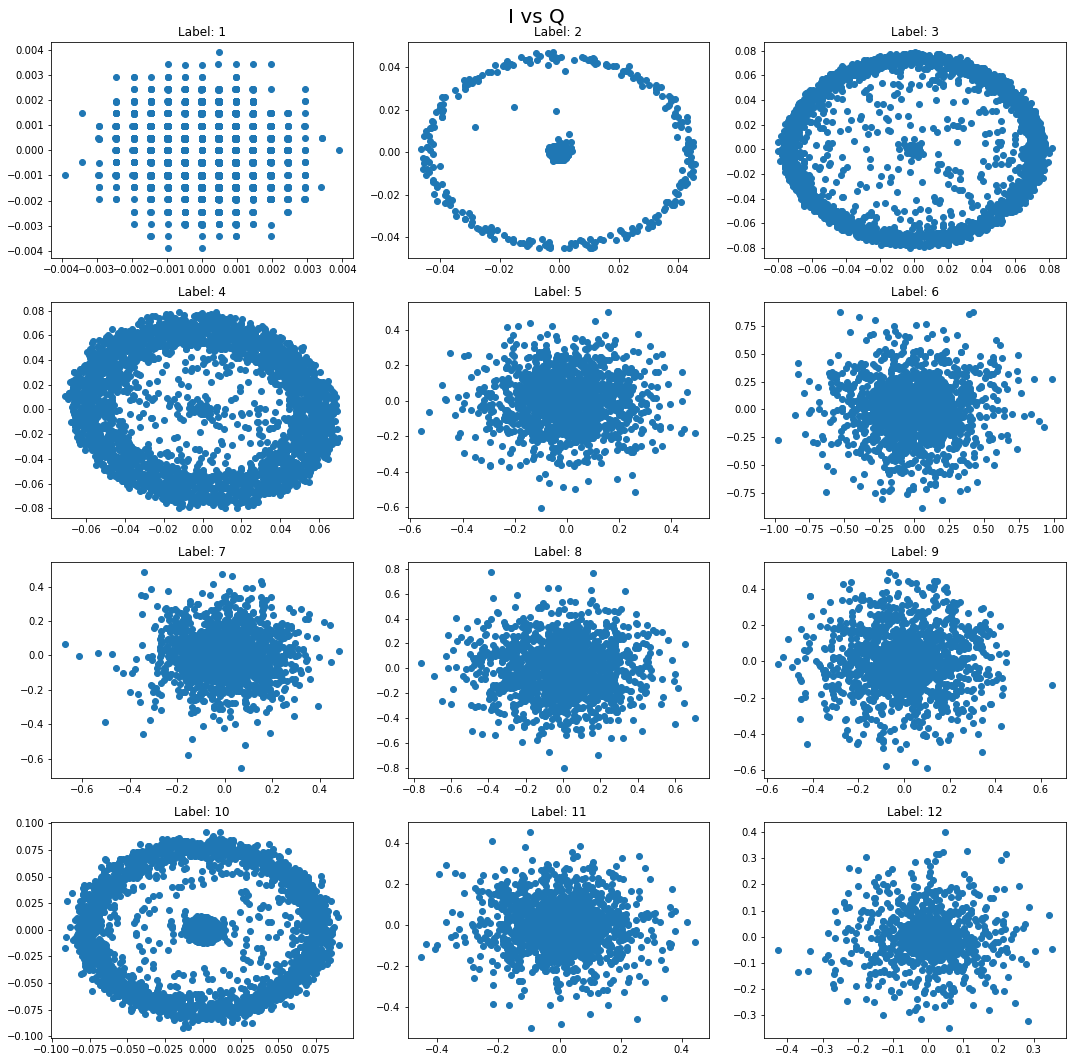

In [30]:
plot_sample_iq_points(1)

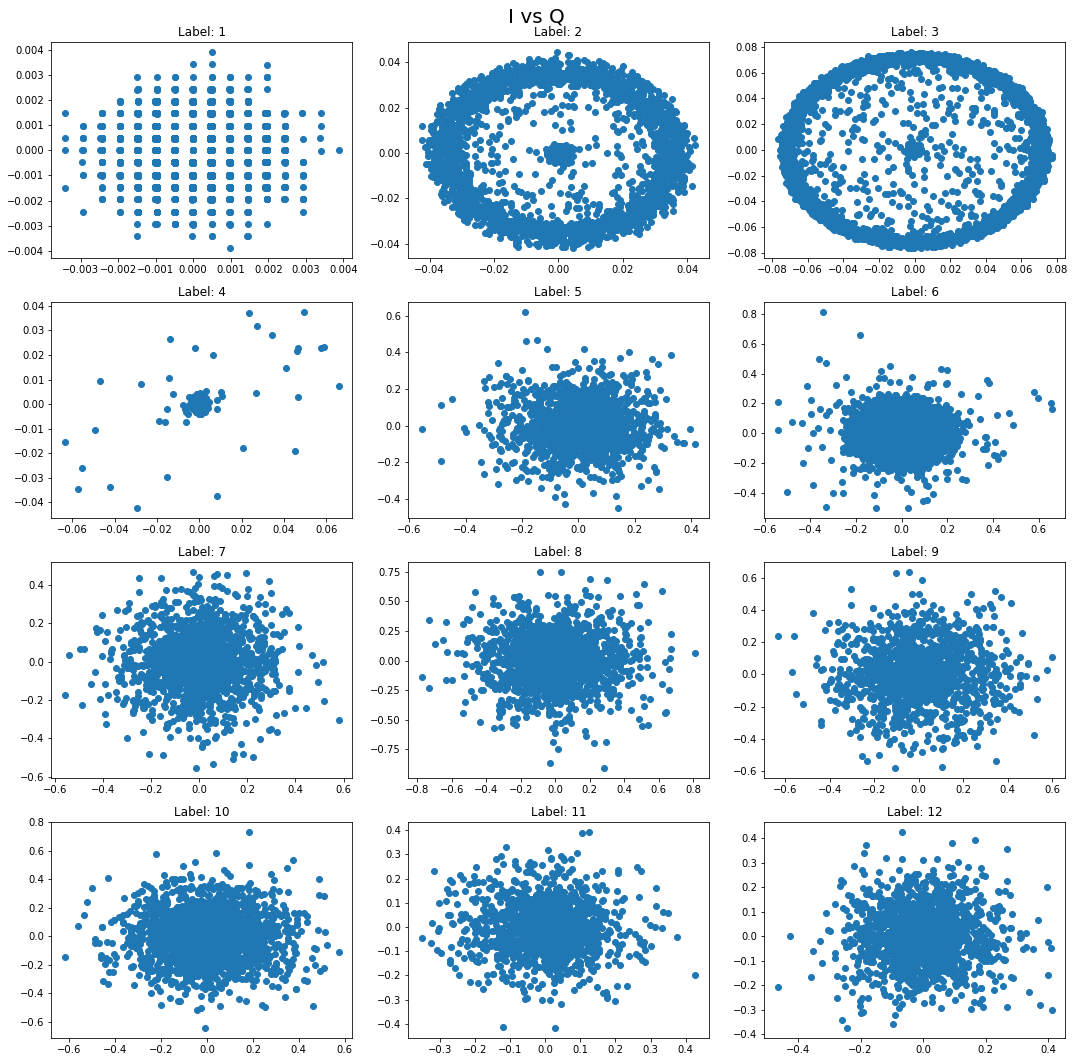

In [31]:
plot_sample_iq_points(5)

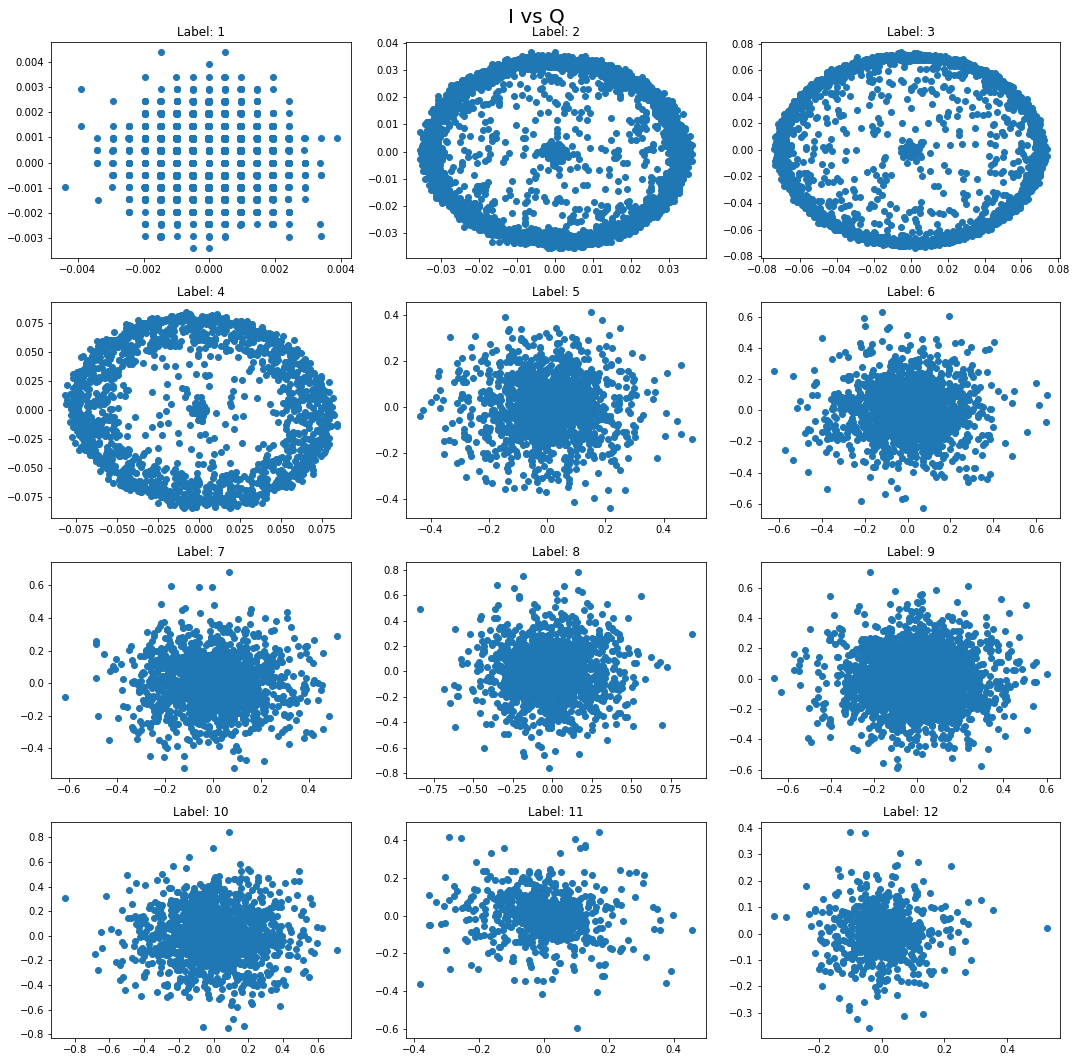

In [32]:
plot_sample_iq_points(10)

In [33]:
def plot_sample_iq_points_same_label(label):
    sample_iq_points = []
    sample_iq_points_idx = index_dict[label][:12]    
    fig, ax = plt.subplots(4, 3, figsize=(15,15))
    fig.suptitle(f'Label: {label}', fontsize=20)
    for i in sample_iq_points_idx:
        sample_iq_points.append(X_iq[i])
    for idx, sample_signal in enumerate(sample_iq_points):
        i_temp = [a[0] for a in sample_signal]
        q_temp = [a[1] for a in sample_signal]
        row, col = idx//3,idx%3
        ax[row][col].scatter(i_temp, q_temp)
    fig.tight_layout()
    plt.show()

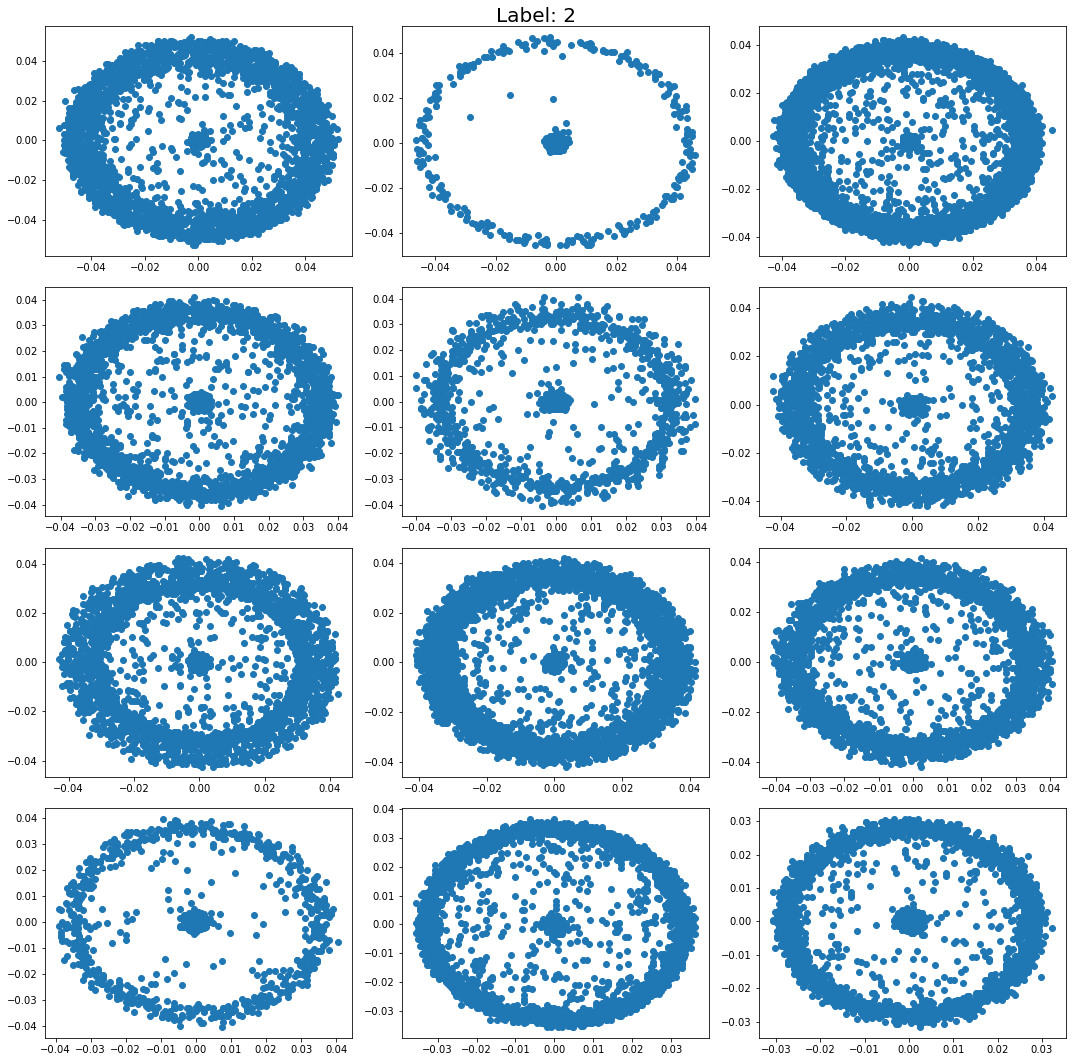

In [34]:
plot_sample_iq_points_same_label(2)

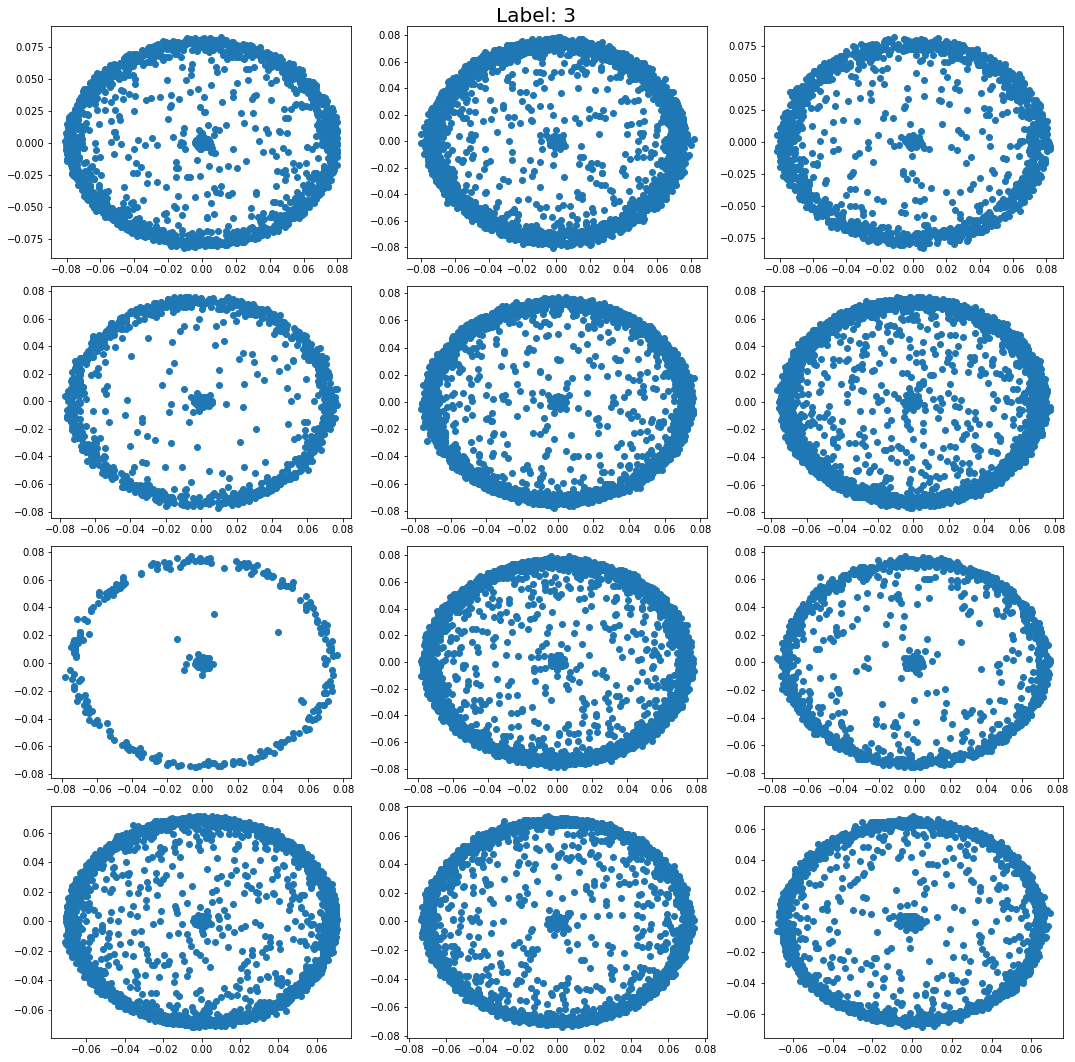

In [35]:
plot_sample_iq_points_same_label(3)

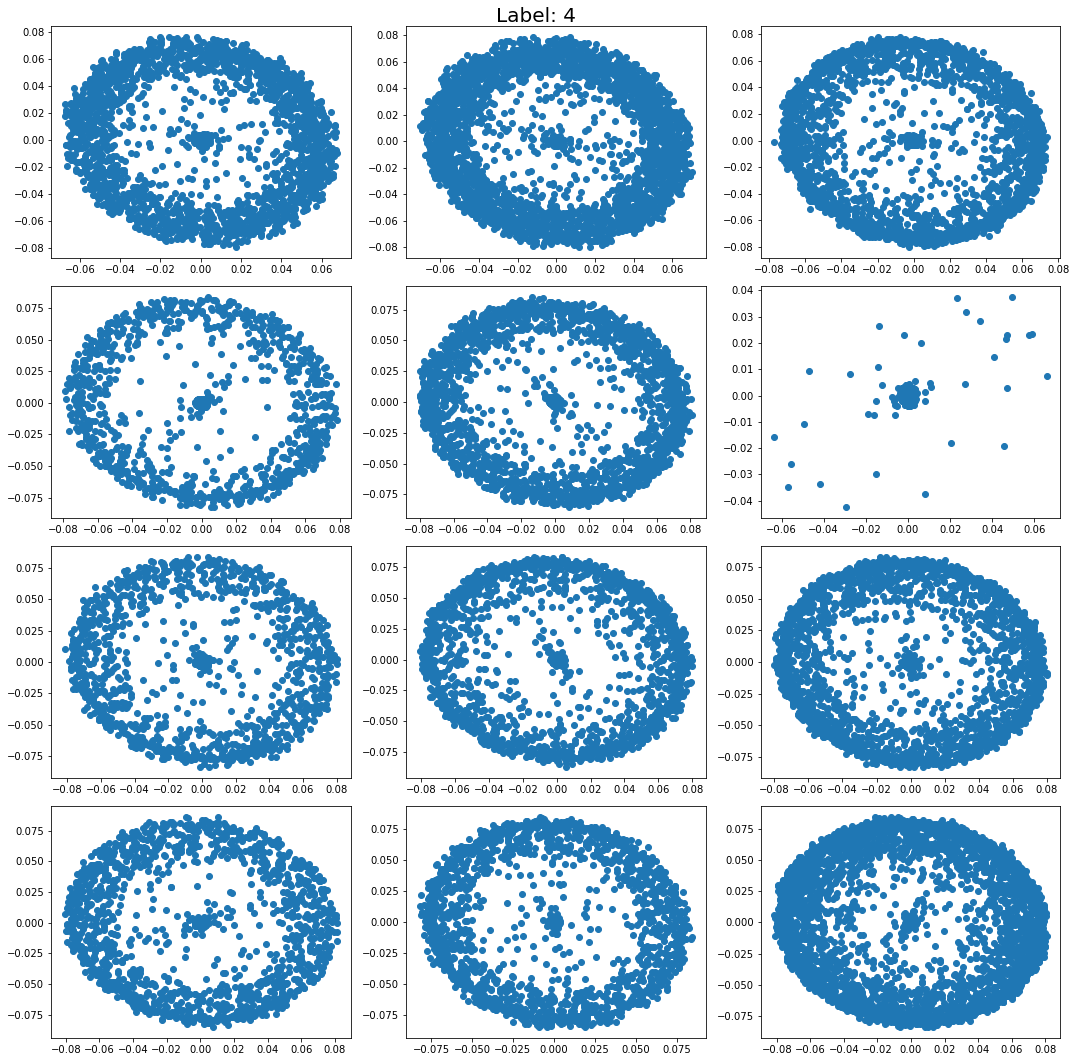

In [36]:
plot_sample_iq_points_same_label(4)

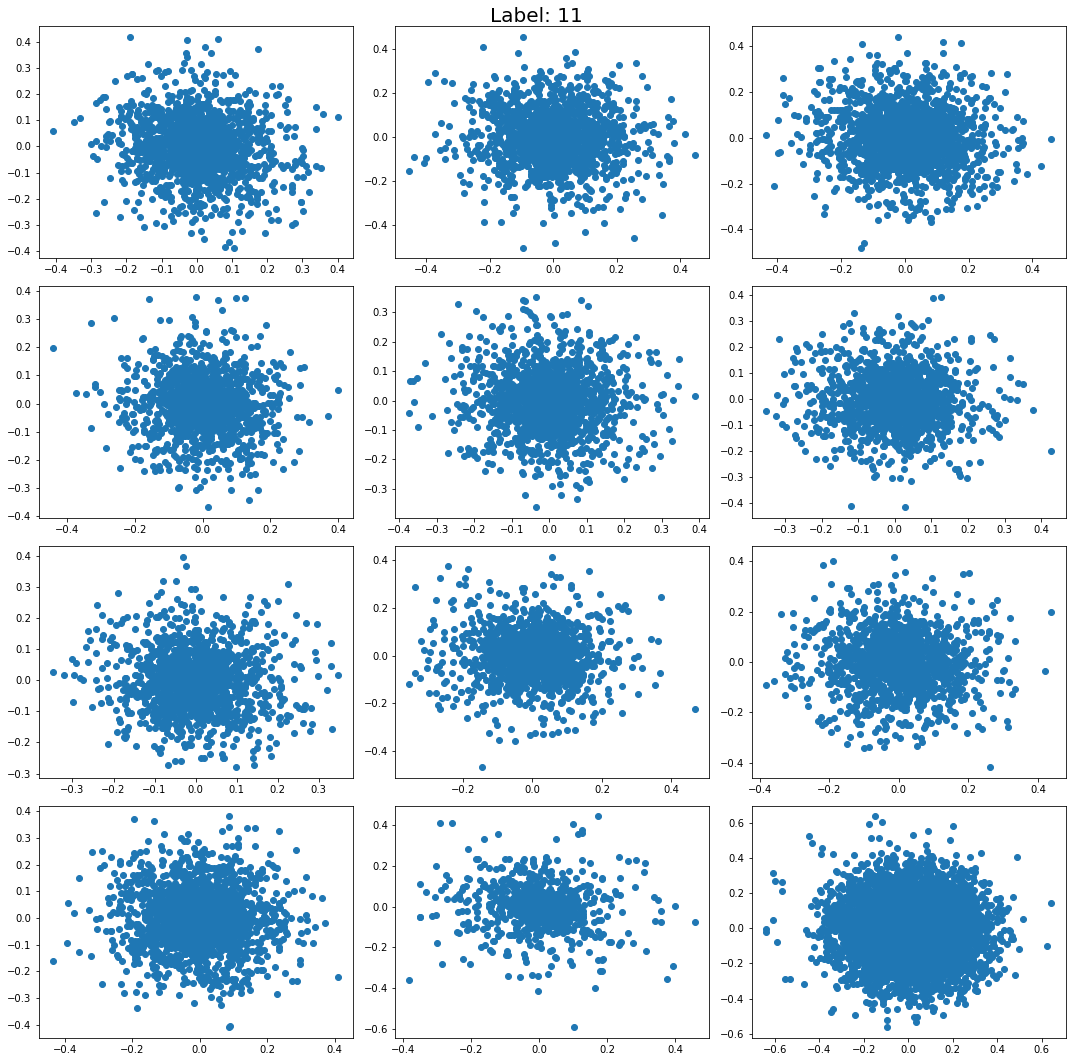

In [37]:
plot_sample_iq_points_same_label(11)

In [38]:
# sample_index_in_indexes = 1
# sample_iq_points = []
# for i in range(1,13):
#     y_actual_index_temp = index_dict[i][sample_index_in_indexes]
#     sample_iq_points.append(X_iq[y_actual_index_temp])

# fig, ax = plt.subplots(4, 3, figsize=(15,15))
# fig.suptitle('I vs Q', fontsize=20)
# for idx, sample_signal in enumerate(sample_iq_points):
#     i_temp = [a[0] for a in sample_signal]
#     q_temp = [a[1] for a in sample_signal]
#     row, col = idx//3,idx%3
#     ax[row][col].set_title(f'Label: {idx+1}')
#     ax[row][col].scatter(i_temp, q_temp);

# Spectrogram Samples

In [39]:
ch_1_spec = []
ch_2_spec = []
chirp_spec = []

ch_1_spec.append(np.load(f'{spectrogram_path}/3.565-Chirp_3.npy'))
ch_1_spec.append(np.load(f'{spectrogram_path}/3.565-Chirp_4.npy'))

ch_2_spec.append(np.load(f'{spectrogram_path}/3.555-Chirp_2.npy'))
ch_2_spec.append(np.load(f'{spectrogram_path}/3.555-Chirp_3.npy'))

chirp_spec.append(np.load(f'{spectrogram_path}/Chirp_1.npy'))
chirp_spec.append(np.load(f'{spectrogram_path}/Chirp_2.npy'))

In [40]:
ch_1_spec_data = np.vstack(ch_1_spec)
ch_2_spec_data = np.vstack(ch_2_spec)
chirp_spec_data = np.vstack(chirp_spec)

In [41]:
X_spec = np.vstack([chirp_spec_data, ch_1_spec_data, ch_2_spec_data])

In [42]:
def plot_sample_spectrograms(sample_index_in_indexes):
    sample_spec_points = []
    for i in range(1,13):
        y_actual_index_temp = index_dict[i][sample_index_in_indexes]
        sample_iq_points.append(X_spec[y_actual_index_temp])
    
    fig, ax = plt.subplots(4, 3, figsize=(15,15))
    fig.suptitle('Spectrogram', fontsize=20)
    for idx, sample_signal_spec in enumerate(sample_spec_points):
        row, col = idx//3,idx%3
        sns.heatmap(sample_signal_spec, ax=ax[row][col])
        ax[row][col].set_title(f'Label: {idx+1}')
    fig.tight_layout()
    plt.show()

In [43]:
def plot_sample_spectrograms_same_label(label):
    sample_spec_points = []
    sample_spec_points_idx = index_dict[label][:12]    
    fig, ax = plt.subplots(4, 3, figsize=(15,15))
    fig.suptitle(f'Label: {label}', fontsize=20)
    for i in sample_spec_points_idx:
        sample_spec_points.append(X_spec[i])
    
    for idx, sample_signal_spec in enumerate(sample_spec_points):
        row, col = idx//3,idx%3
        sns.heatmap(sample_signal_spec, ax=ax[row][col])
    fig.tight_layout()
    plt.show()

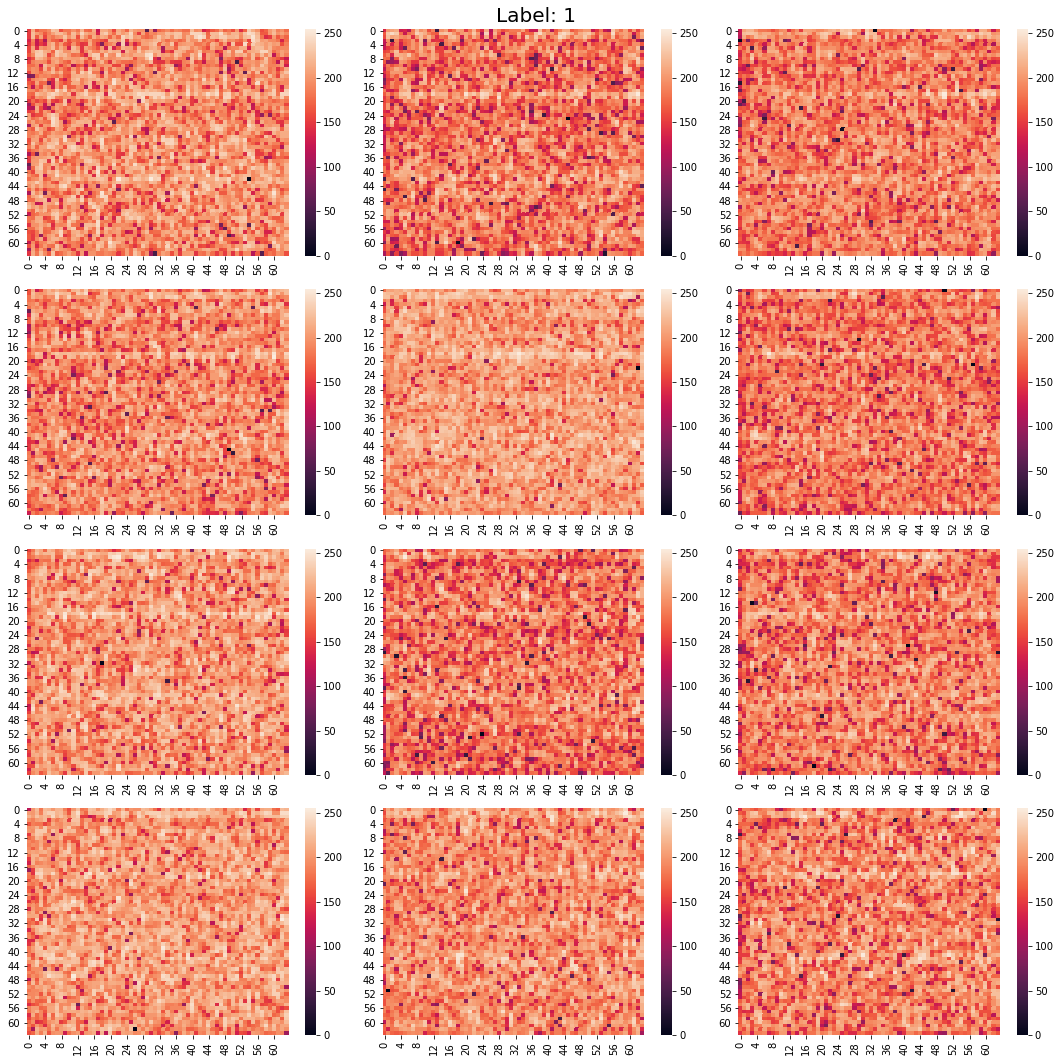

In [44]:
plot_sample_spectrograms_same_label(1)

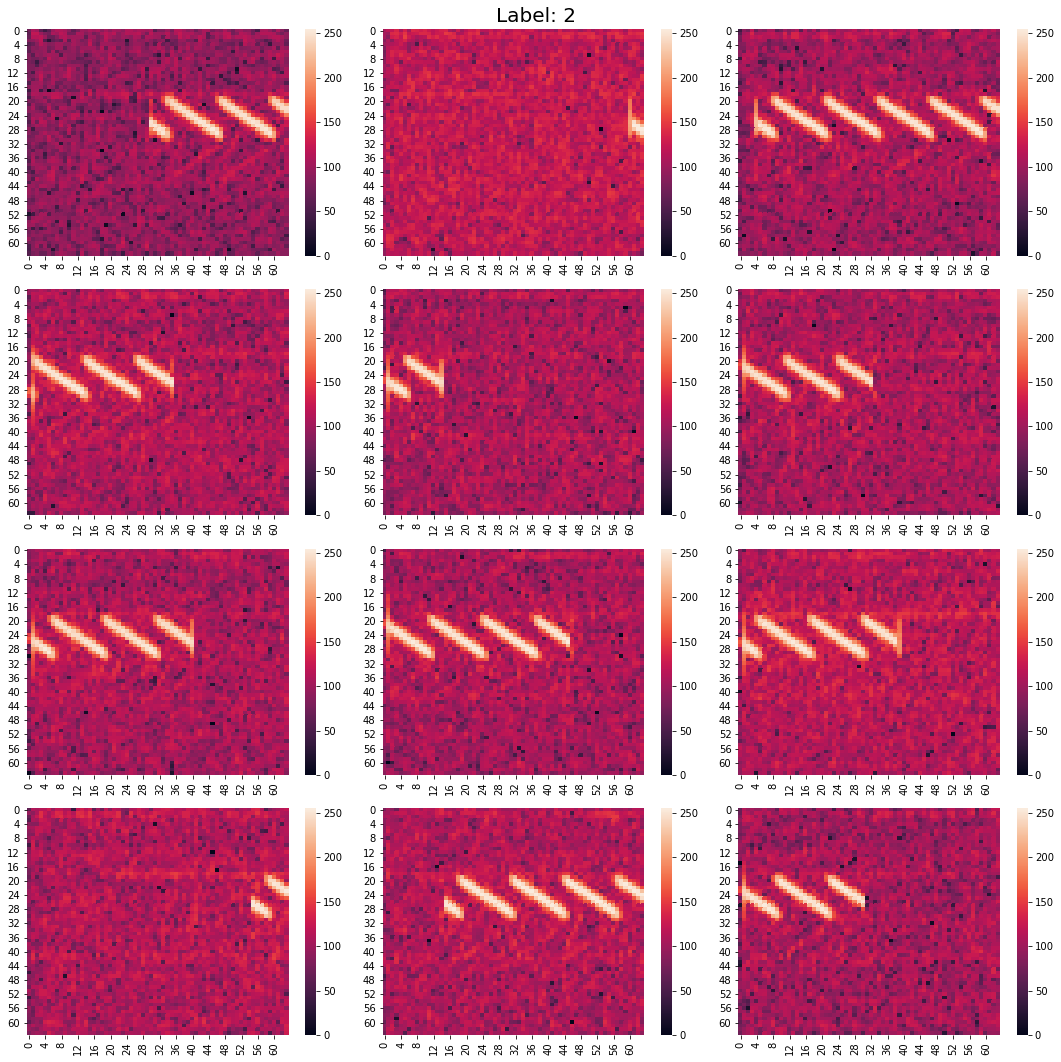

In [45]:
plot_sample_spectrograms_same_label(2)

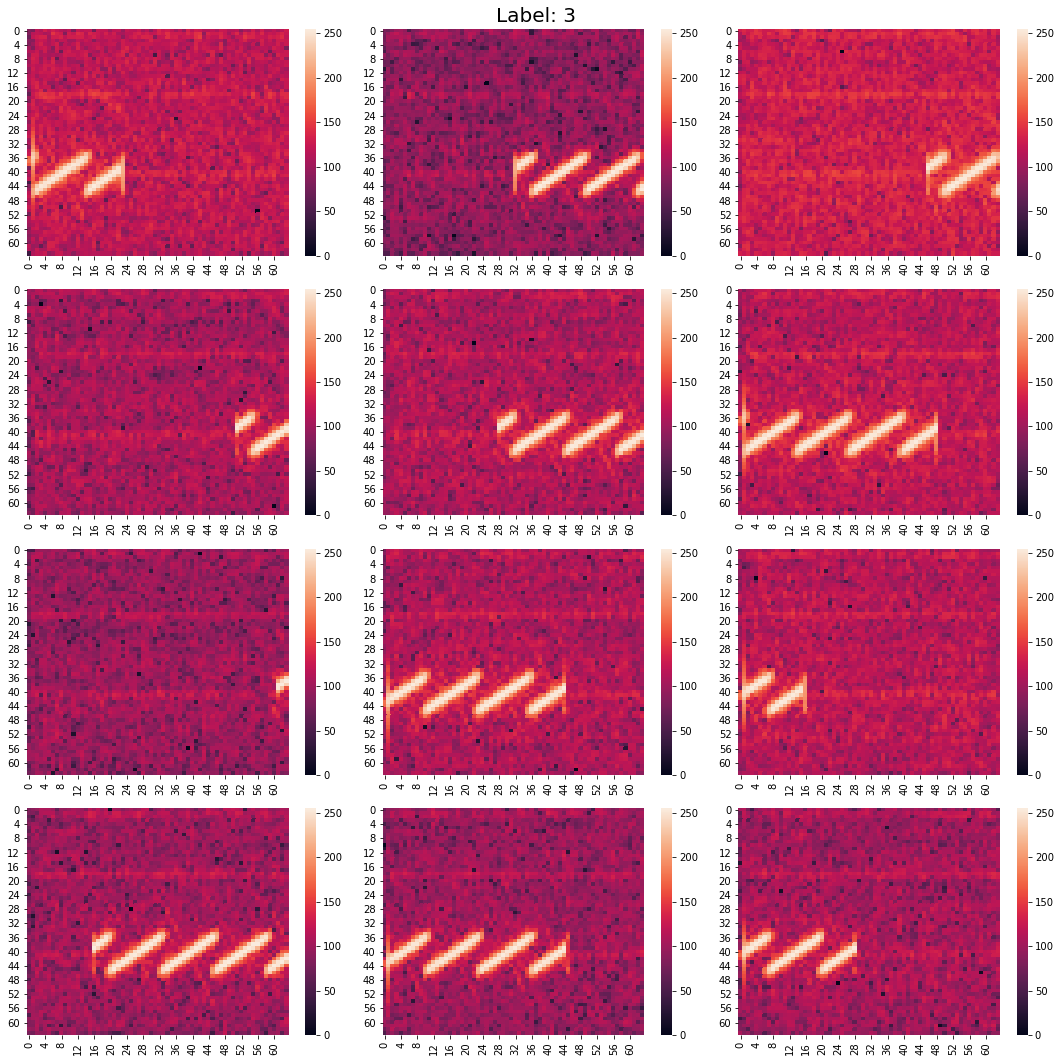

In [46]:
plot_sample_spectrograms_same_label(3)

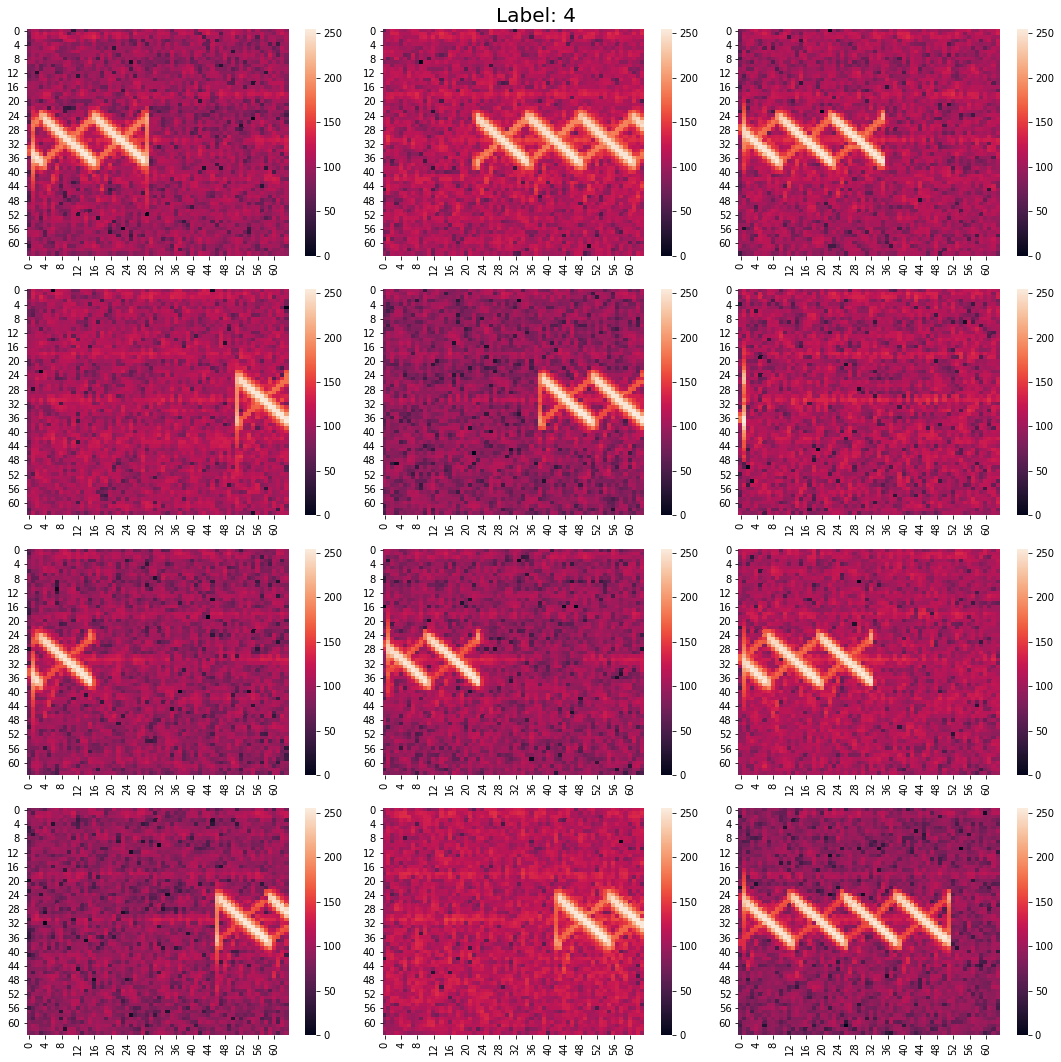

In [47]:
plot_sample_spectrograms_same_label(4)

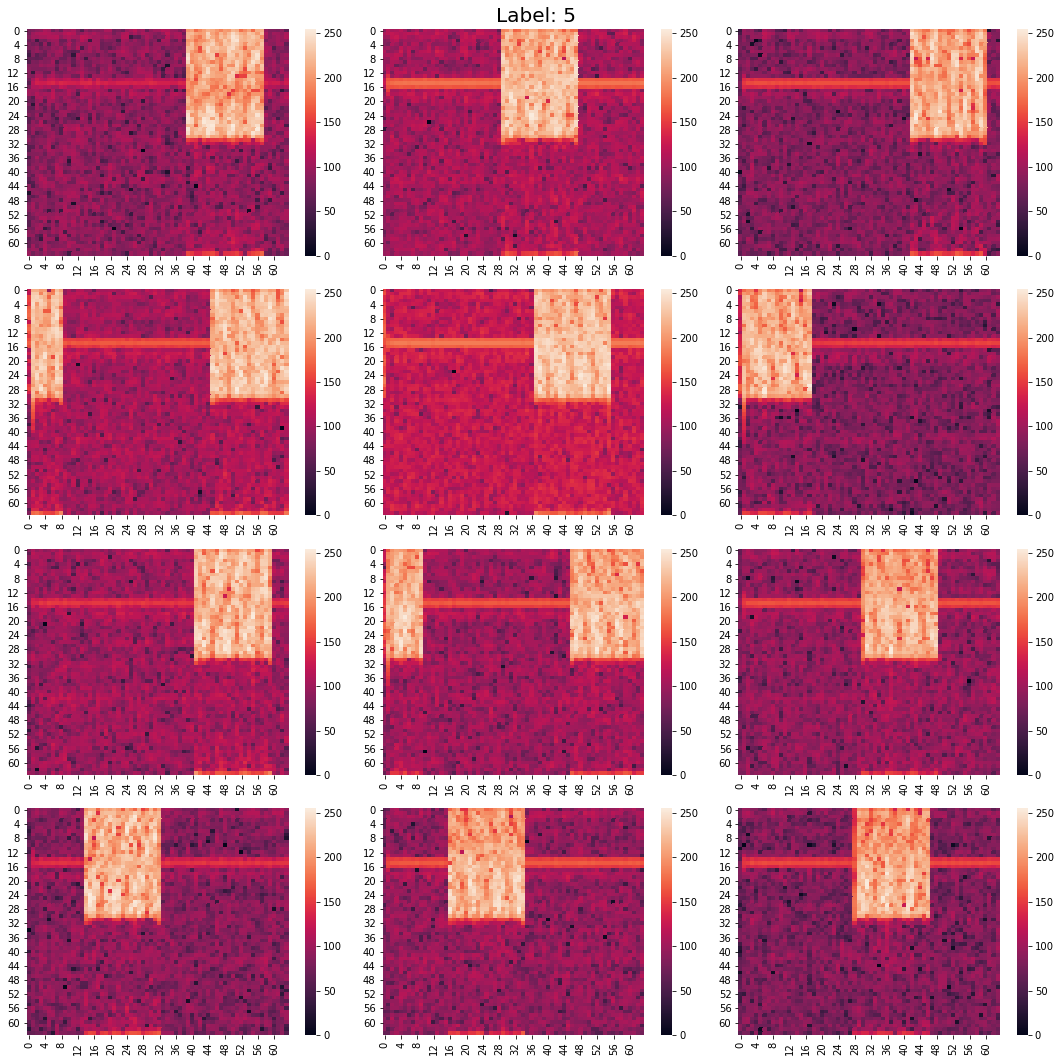

In [48]:
plot_sample_spectrograms_same_label(5)

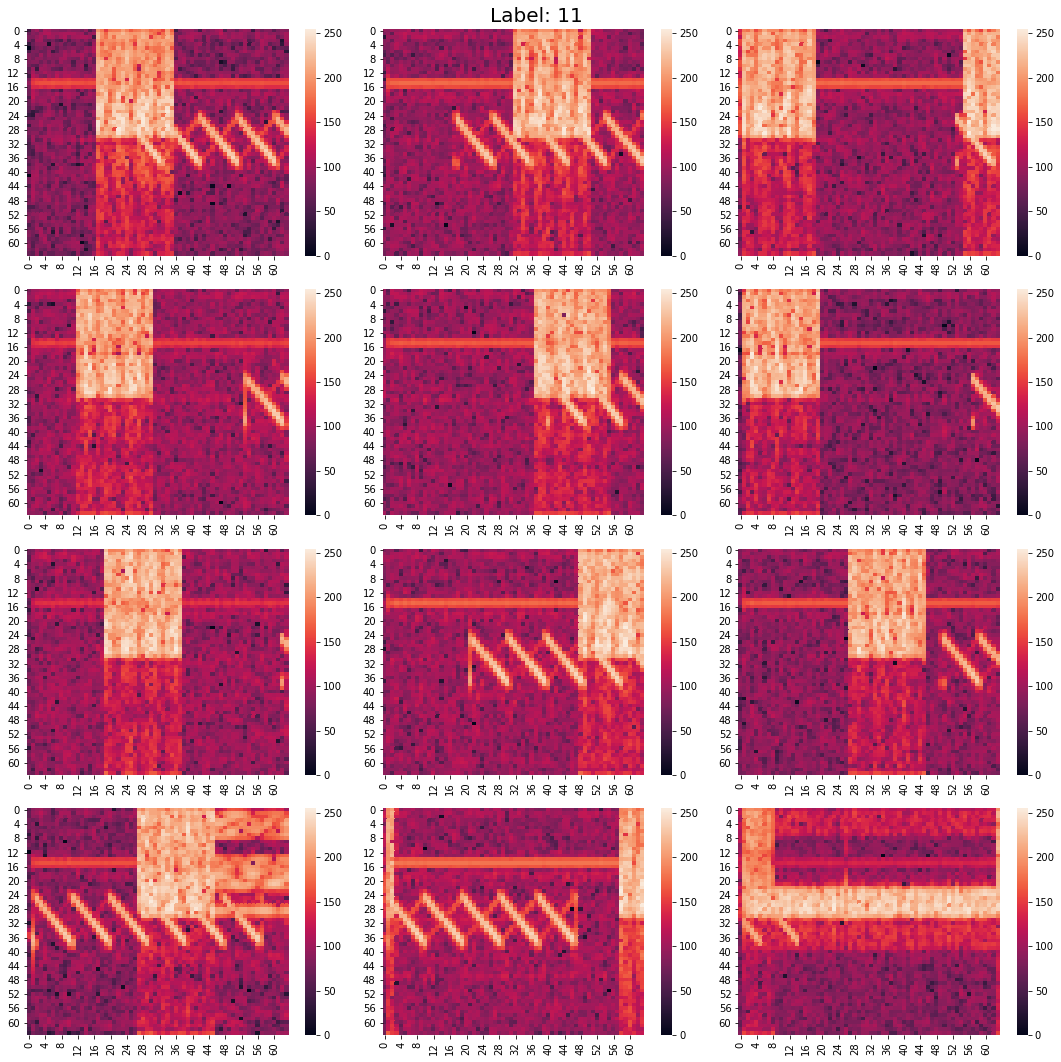

In [49]:
plot_sample_spectrograms_same_label(11)

# Simple RF Model on IQ Stats

In [50]:
def preprocess_signal(x):
    i = np.array([real[0] for real in x])
    q = np.array([imag[1] for imag in x])
    i_max = i.max()
    q_max = q.max()
    i_min = i.min()
    q_min = q.min()
    i_mean = i.mean()
    q_mean = q.mean()
    i_range = i_max - i_min
    q_range = q_max - q_min
    threshold_val = 0.1
    num_pts_away_q = (q > threshold_val).sum()
    num_pts_away_q += (q < -1*threshold_val).sum()
    num_pts_away_i = (i > threshold_val).sum()
    num_pts_away_i += (i < -1*threshold_val).sum()
    temp = {
        "i_max": i_max,
        "q_max": q_max,
        "i_min": i_min,
        "q_min": q_min,
        "i_mean": i_mean,
        "q_mean": q_mean,
        "i_range": i_range,
        "q_range": q_range,
        "num_pts_away_q": num_pts_away_q,
        "num_pts_away_i": num_pts_away_i,
    }
    return temp

In [51]:
X_iq_preprocessed = Parallel(n_jobs=4)(delayed(preprocess_signal)(x) for x in tqdm(X_iq))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49194/49194 [00:49<00:00, 990.49it/s]


In [52]:
df = pd.DataFrame(X_iq_preprocessed)

In [53]:
df.head()

,i_max,q_max,i_min,q_min,i_mean,q_mean,i_range,q_range,num_pts_away_q,num_pts_away_i
0,0.067812,0.076601,-0.067354,-0.079531,0.000028,0.001093,0.135166,0.156132,0,0
1,0.070254,0.079043,-0.070742,-0.080050,-0.000617,0.000457,0.140996,0.159093,0,0
2,0.073672,0.078066,-0.077090,-0.080020,0.000319,0.000752,0.150762,0.158086,0,0
3,0.003906,0.003876,-0.003906,-0.003418,0.000003,0.000016,0.007812,0.007294,0,0
4,0.052187,0.052217,-0.052187,-0.052705,-0.000063,0.000064,0.104374,0.104922,0,0


In [54]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

In [55]:
clf = RandomForestClassifier(max_depth=8, random_state=12)

In [56]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, random_state=12)

In [57]:
y_pred = clf.predict(X_test)

In [58]:
accuracy_score(y_test, y_pred)

0.779524358018836